In [456]:
import pandas as pd
pd.set_option('display.max_columns',100)

import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore

In [364]:
main_df = pd.read_csv('main_updated.csv')
hist_df = pd.read_csv('hist_updated.csv')

In [366]:
main_df = main_df.drop(['Unnamed: 0'], axis=1)
hist_df = hist_df.drop(['Unnamed: 0'], axis=1)

In [367]:
main_df.head(1)

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.3,10025,0.0,359.29,0.095919,0.088347,58.995952,0,831.8,41.76,41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.0,Stayed


In [368]:
hist_df.head(1)

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,churn
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0


## Feature engineering

Since we have the consumption data for each of the companies for the year 2015, we will create new features using the average of the year, the
last six months, and the last three months to our model.


In [471]:
mean_year = hist_df.groupby(["id"]).mean().reset_index()

In [472]:
mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var",
 "price_p2_var": "mean_year_price_p2_var",
"price_p3_var": "mean_year_price_p3_var",
"price_p1_fix": "mean_year_price_p1_fix",
"price_p2_fix": "mean_year_price_p2_fix",
"price_p3_fix": "mean_year_price_p3_fix",})
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"]
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"]
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

In [473]:
features = mean_year

In [474]:
features.churn = features.churn.replace({0:'Stayed',1:'Churned'})

In [371]:
mean_year.head()

,id,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,churn,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,0.0,40.826071,24.524832,16.353854
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,0.0,44.531877,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,0.0,45.501268,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,0.0,40.766185,24.486748,16.328003
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,0.0,44.414856,0.000000,0.000000


We will define a variable tenure = date_end - date_activ

In [372]:
main_df.date_activ.dtype

dtype('O')

In [373]:
main_df.date_end = pd.to_datetime(main_df.date_end)
main_df.date_activ = pd.to_datetime(main_df.date_activ)
main_df["tenure"] = (round((main_df["date_end"] - main_df["date_activ"])/ np.timedelta64(1, "Y")).astype(int))

In [374]:
main_df.head(2)

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,tenure
0,48ada52261e7cf58715202705a0451c9,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,0,831.8,41.76,41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.0,Stayed,4
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.8,Stayed,7


In [375]:
main_df.churn = main_df.churn.replace({'Stayed':'Churned' ,'Churned': 'Stayed'})

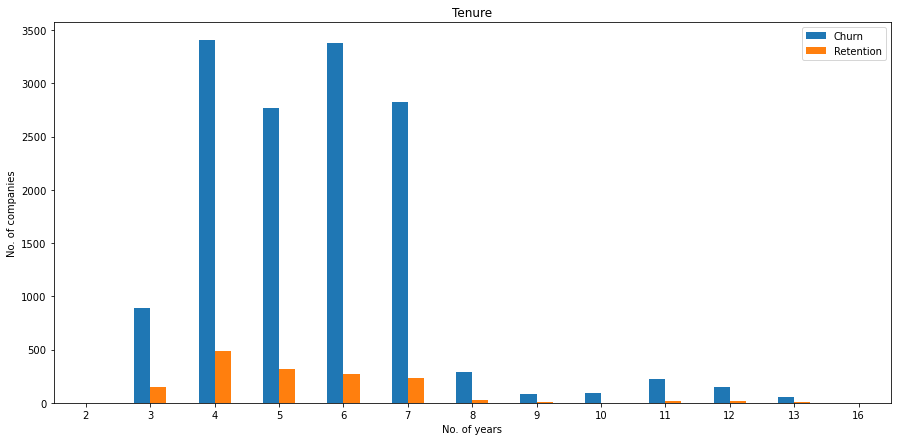

In [376]:
tenure = main_df[["churn","tenure", "id"]].groupby(["tenure","churn"])["id"].count().unstack(level=1)
tenure_percentage = (tenure.div(tenure.sum(axis=1), axis=0)*100)

tenure.plot(kind="bar",figsize=(15,7),stacked=False,rot=0,title= "Tenure")

plt.legend(["Churn","Retention"], loc="upper right")
plt.ylabel("No. of companies")
plt.xlabel("No. of years")
plt.show()

We can see that churn is very low for companies which joined recently or that have made the contract a long time ago, but the higher number of
churners within the 3-7 years of tenure.

---
We will transform the dates provided in a way that we can make more sense out of them.
- months_activ : Number of months active until reference date (Jan 2016)
- months_to_end : Number of months of the contract left at reference date (Jan 2016)
- months_modif_prod : Number of months since last modification at reference date (Jan 2016)
- months_renewal : Number of months since last renewal at reference date (Jan 2016)


In [377]:
main_df.date_modif_prod = pd.to_datetime(main_df.date_modif_prod)
main_df.date_renewal = pd.to_datetime(main_df.date_renewal)

In [378]:
def convert_months(reference_date, dataframe, column):
     """
     Input a column with timedeltas and return months
     """
     time_delta = REFERENCE_DATE - dataframe[column]
     months = (time_delta / np.timedelta64(1, "M")).astype(int)
     return months

In [379]:
REFERENCE_DATE = '2016-01-01'
REFERENCE_DATE = np.datetime64(REFERENCE_DATE)

In [380]:
main_df["months_activ"] = convert_months(REFERENCE_DATE, main_df, "date_activ")
main_df["months_to_end"] = -convert_months(REFERENCE_DATE, main_df, "date_end")
main_df["months_modif_prod"] = convert_months(REFERENCE_DATE, main_df, "date_modif_prod")
main_df["months_renewal"] = convert_months(REFERENCE_DATE, main_df, "date_renewal")

In [381]:
main_df.drop(columns=["date_activ", "date_end", "date_modif_prod", "date_renewal"],inplace=True)

#### We will convert Categorical data with dummy variables

In [383]:
main_df.origin_up = main_df.origin_up.astype("category")
main_df.origin_up.value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7590
kamkkxfxxuwbdslkwifmmcsiusiuosws    4489
ldkssxwpmemidmecebumciepifcamkci    3592
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [384]:
categories_origin = pd.get_dummies(main_df["origin_up"], prefix = "origin")
categories_origin.columns = [col_name[:10] for col_name in categories_origin.columns]
categories_origin.head(3)

,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa
0,0,0,1,0,0
1,0,1,0,0,0
2,0,1,0,0,0


In [385]:
main_df = pd.merge(main_df, categories_origin, left_index=True, right_index=True)

#### We will check for high correlated variables to avoid Multicollinearity

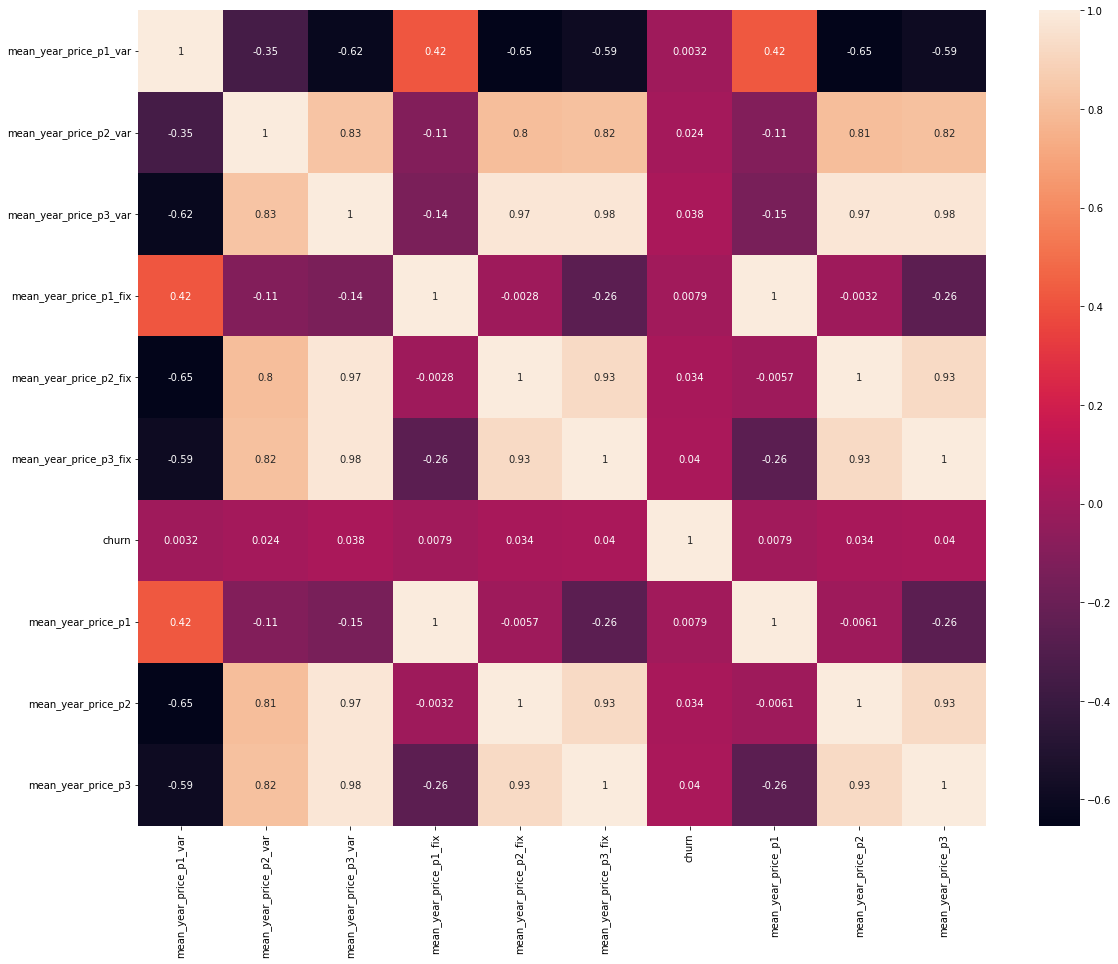

In [435]:
correlation = features.corr()


plt.figure(figsize=(19,15))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
 yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

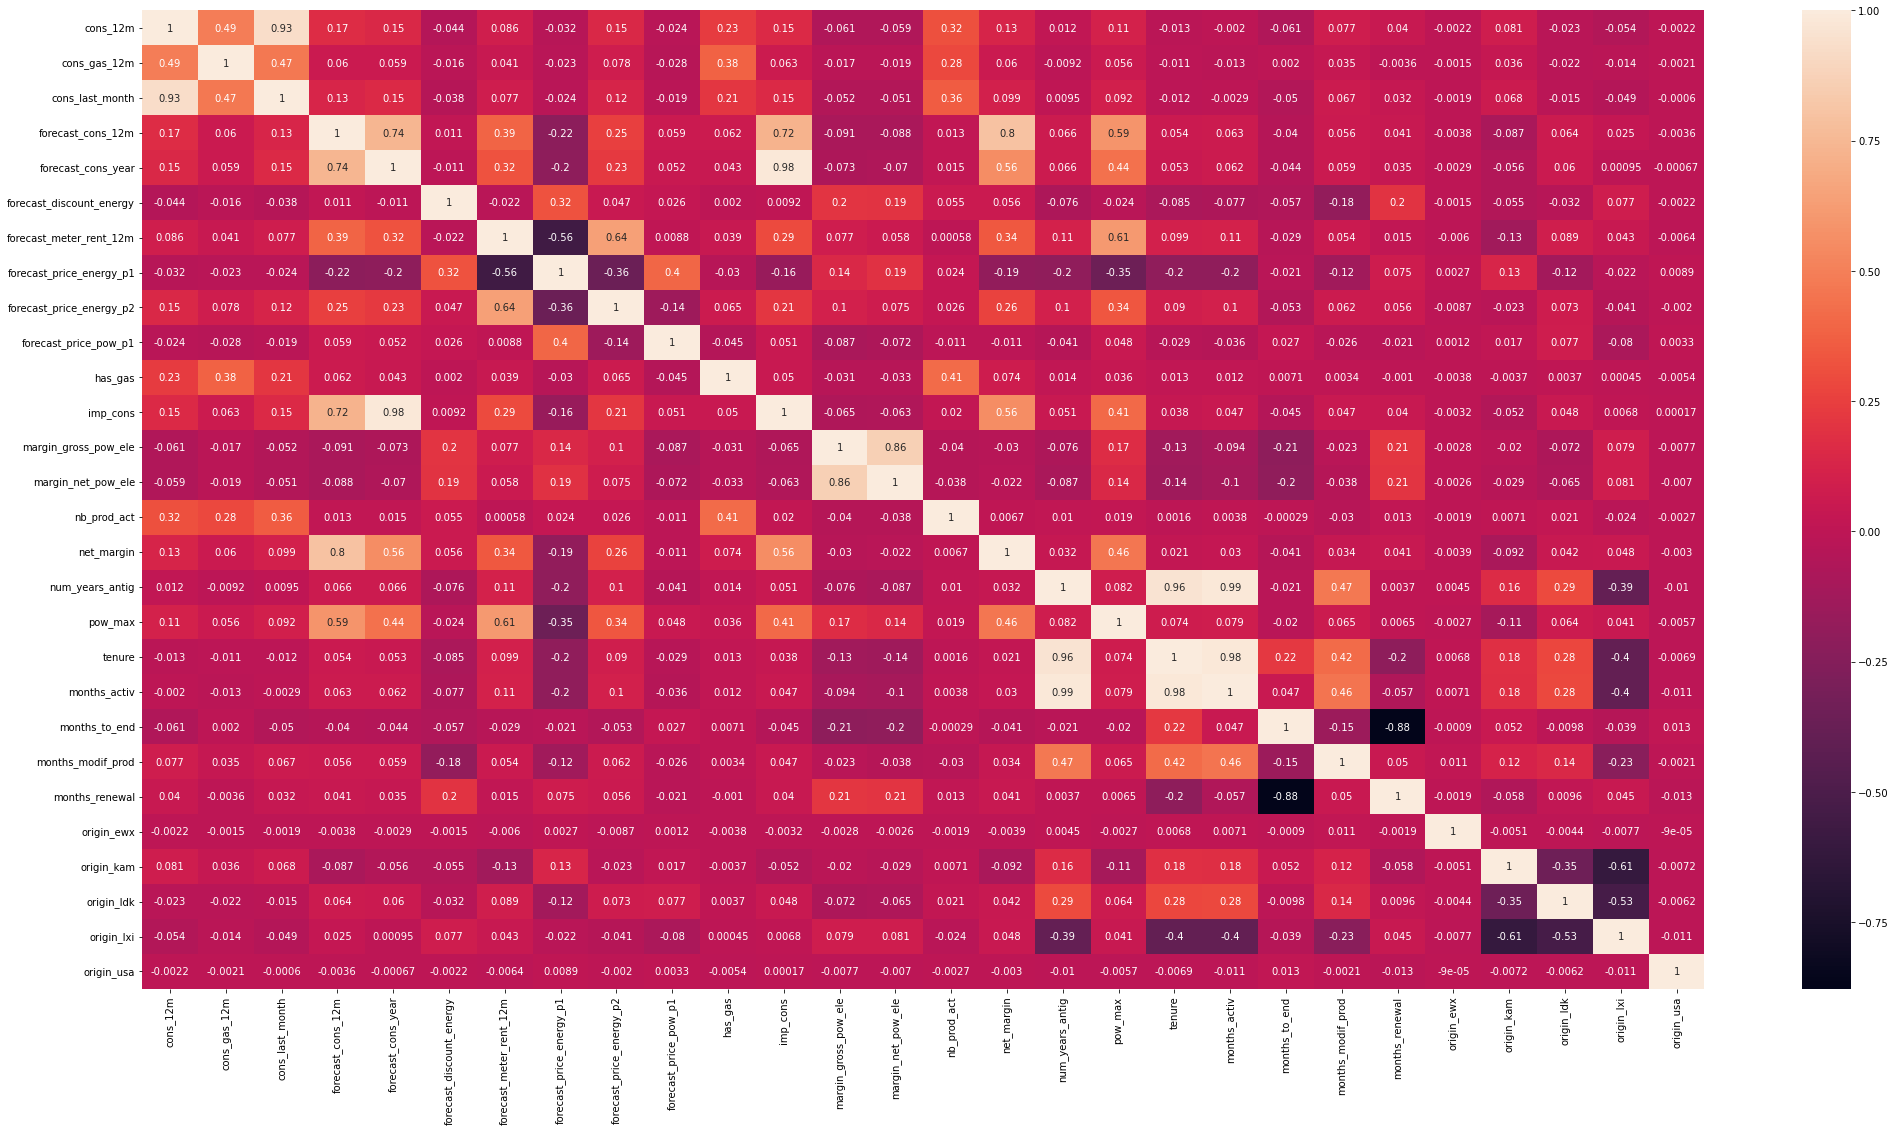

In [438]:
correlation = main_df.corr()

plt.figure(figsize=(35,18))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
 yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [439]:
main_df.drop(columns=["num_years_antig", "forecast_cons_year"],inplace=True)

###  Removing the outliers in the data

In [457]:
def replace_outliers_z_score(dataframe, column, Z=3):
 """
 Replace outliers with the mean values using the Z score.
 Nan values are also replaced with the mean values.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound replaced with mean
 """
 
 df = dataframe.copy(deep=True)
 df.dropna(inplace=True, subset=[column])

 # Calculate mean without outliers
 df["zscore"] = zscore(df[column])
 mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()

 # Replace with mean values
 dataframe[column] = dataframe[column].fillna(mean_)
 dataframe["zscore"] = zscore(dataframe[column])
 no_outliers = dataframe[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z)].shape[0]
 dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_

 # Print message
 print("Replaced:", no_outliers, " outliers in ", column)
 return dataframe.drop(columns="zscore")

In [475]:
for c in features.columns:
    if c != "id" and c != "churn":
        features = replace_outliers_z_score(features,c)

Replaced: 277  outliers in  mean_year_price_p1_var
Replaced: 0  outliers in  mean_year_price_p2_var
Replaced: 0  outliers in  mean_year_price_p3_var
Replaced: 122  outliers in  mean_year_price_p1_fix
Replaced: 0  outliers in  mean_year_price_p2_fix
Replaced: 0  outliers in  mean_year_price_p3_fix
Replaced: 123  outliers in  mean_year_price_p1
Replaced: 0  outliers in  mean_year_price_p2
Replaced: 0  outliers in  mean_year_price_p3


In [479]:
main_df = replace_outliers_z_score(main_df,"cons_12m")
main_df = replace_outliers_z_score(main_df,"cons_gas_12m")
main_df = replace_outliers_z_score(main_df,"cons_last_month")
main_df = replace_outliers_z_score(main_df,"forecast_cons_12m") 
main_df = replace_outliers_z_score(main_df,"forecast_discount_energy")
main_df = replace_outliers_z_score(main_df,"forecast_meter_rent_12m") 
main_df = replace_outliers_z_score(main_df,"forecast_price_energy_p1") 
main_df = replace_outliers_z_score(main_df,"forecast_price_energy_p2")
main_df = replace_outliers_z_score(main_df,"forecast_price_pow_p1") 
main_df = replace_outliers_z_score(main_df,"imp_cons") 
main_df = replace_outliers_z_score(main_df,"margin_gross_pow_ele") 
main_df = replace_outliers_z_score(main_df,"margin_net_pow_ele")
main_df = replace_outliers_z_score(main_df,"net_margin")
main_df = replace_outliers_z_score(main_df,"pow_max")
main_df = replace_outliers_z_score(main_df,"months_activ")
main_df = replace_outliers_z_score(main_df,"months_to_end") 
main_df = replace_outliers_z_score(main_df,"months_modif_prod")
main_df = replace_outliers_z_score(main_df,"months_renewal")

Replaced: 379  outliers in  cons_12m
Replaced: 283  outliers in  cons_gas_12m
Replaced: 330  outliers in  cons_last_month
Replaced: 253  outliers in  forecast_cons_12m
Replaced: 555  outliers in  forecast_discount_energy
Replaced: 361  outliers in  forecast_meter_rent_12m
Replaced: 297  outliers in  forecast_price_energy_p1
Replaced: 0  outliers in  forecast_price_energy_p2
Replaced: 156  outliers in  forecast_price_pow_p1
Replaced: 199  outliers in  imp_cons
Replaced: 234  outliers in  margin_gross_pow_ele
Replaced: 223  outliers in  margin_net_pow_ele
Replaced: 175  outliers in  net_margin
Replaced: 287  outliers in  pow_max
Replaced: 451  outliers in  months_activ
Replaced: 2  outliers in  months_to_end
Replaced: 136  outliers in  months_modif_prod
Replaced: 128  outliers in  months_renewal


### Saving The changes.

In [484]:
main_df.to_csv("main_after_feature.csv")
features.to_csv("hist_after_feature.csv")